The class LBP implemented bellow is a template for the LBP algorithm.

The constructor takes 3 parameters - neighbor_collection, pixel_description, descriptors_final_processing. All of these parameters are callable function which shall be used to perfrom the feature extraction for and Image.

The LBP class has one public method - get_feature_vector, which returns the feature vector based on provided arguments:
  - image - 2D numpy array of ints representing the image
  
You can pass your own functions as this parameters, you just need to make sure that their interfaces enable mutual interaction:
  - output of neighbor_collection will be used as an input for pixel_description
  - output of pixel_description will be added to 2D list representing the image description - this 2D list will then be passed to descriptors_final_processing
  - descriptors_final_processing is returned from the get_feature_vector method, so the provided function should return a 1D numpy array
  
Please note that for the functions used only in the LBP template we are leaving their API on you, so you are not limited by our expectations. Only limitations is that the descriptors_final_processing has to return a 1D numpy array.

Check the cells bellow to see examples of the usage.

In [1]:
import numpy as np
from collections.abc import Callable
from typing import List

class LBP:
    
    def __init__(self, 
                neighbor_collection: Callable,
                pixel_description: Callable,
                descriptors_final_processing: Callable,
                ):
        self._neighbor_collection = neighbor_collection
        self._pixel_description = pixel_description
        self._descriptors_final_processing = descriptors_final_processing
        
    def get_feature_vector(self, image: np.ndarray, radius: int, overlaps: int) -> np.ndarray:
        # check the provided image type
        if image.dtype != np.uint8 or image.ndim != 2:
            raise ValueError(f'Invalid image shape or type, you provided me with type {image.dtype} and dim {image.ndim} ')
            
        # iteration step is based on the radius of the field that should be covered and a demanded overlap
        iteration_step = 2 * radius + 1 - overlaps
        
        # checks that the iteration step is not negative, so there will not be an infinite loop
        assert(2 * radius + 1 - overlaps > 0)
        
        # todo preprocess image? For example adding a padding so all the pixels can have a descriptor or smth like that
        descriptor_2D = self._get_descriptor_2D(image, radius, iteration_step)
        
        # processes the final, could simply flatten the descriptor, or can
        # perform more complicated operations like histogram counting etc.
        return self._descriptors_final_processing(descriptor_2D)
    
    def _get_descriptor_2D(self, image: np.ndarray, radius: int, iteration_step: int) -> List[List[int]]:
        if image.dtype != np.uint8 or image.ndim != 2:
            raise ValueError(f'Invalid image shape or type, you provided me with type {image.dtype} and dim {image.ndim} ')
        # we will iterate over the image and prepare a 2D list of descriptors for each available pixel
        descriptor = []
        for row in range(radius, image.shape[0] - radius, iteration_step):
            descriptor.append([])
            for col in range(radius, image.shape[1] - radius, iteration_step):
                
                # handles computing of a descriptor for a given pixel
                pixel_descriptor = self._get_pixel_descriptor(image, row, col, radius)
                descriptor[-1].append(pixel_descriptor)
        
        return descriptor
    
    def _get_pixel_descriptor(self, image: np.ndarray, row: int, col: int, radius: int):
        if image.dtype != np.uint8 or image.ndim != 2:
            raise ValueError(f'Invalid image shape or type, you provided me with type {image.dtype} and dim {image.ndim} ')
        # using provided function, extract the neighbors needed for a descriptor counting at a given pixel
        indexes_to_visit = self._neighbor_collection(row, col, radius)
        
        # using provided function, calculate the descriptor of a given pixel
        return self._pixel_description(image, indexes_to_visit, row, col)
                

Check the cells bellow to see one possible implemntation of LBP functions.

In [2]:
def neighbor_collection_full_square(row, col, radius):
    """ 
    Returns indexes around [row, col] pixel based on radius. The square around is defined by the central pixel [row, col] 
    and a radius - the closest point on the border of the square is exactly radius far from the central pixel - [row, col]
    """
    indexes_to_visit = set()
    for r in range(radius + 1):
        for c in range(radius + 1):
            if r == 0 and c == 0: # ignore the central pixel
                continue
            new_indexes_to_visit = {(row + r, col + c), (row + r, col - c), (row - r, col + c), (row - r, col - c)}
            for ind in new_indexes_to_visit:
                indexes_to_visit.add(ind)
    return indexes_to_visit

In [3]:
def binatodeci(binary):
    # taken from https://stackoverflow.com/questions/64391524/python-converting-binary-list-to-decimal
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

def get_pixel_description_as_one_number(image, indexes_to_visit, row, col):
    central_val = image[row, col] # recent pixel value
    other_vals = [image[r_i, c_i] for r_i, c_i in sorted(list(indexes_to_visit))]

    res_bin = [1 if central_val >= x else 0 for x in other_vals]
    
    return binatodeci(res_bin)    

In [4]:
def descriptors_final_processing_plain_flatting(image_desc):
    return np.concatenate(image_desc)

There is one full running example, runned with one testing image
TODO - add image from new data, this one is from homework 1

In [5]:
from PIL import Image
# load image and convert it to gray scale and a shape 128x128 
img = Image.open("test_img.png").convert('L')
img = img.resize((128, 128))
img = np.array(img)

In [6]:
test_lbp = LBP(neighbor_collection_full_square, get_pixel_description_as_one_number, descriptors_final_processing_plain_flatting)
feature_vector = test_lbp.get_feature_vector(img, 1, 0)

You can also take a look how the visualized feature vector converted back to 2D array-like structure looks. Please note that the visulization of feature vector may fail for some setups, as the math.sqrt(feature_vector_length) must result in integer, for the reshape to be possible.

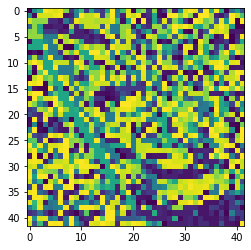

In [7]:
import math
from matplotlib import pyplot as plt
descriptor_2D = feature_vector.reshape((int(math.sqrt(feature_vector.shape[0])), int(math.sqrt(feature_vector.shape[0]))))
# visu img
plt.imshow(descriptor_2D)
plt.show()